In [3]:
import nasdaqdatalink as ndl
import pandas as pd
from ta import add_all_ta_features
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np


In [ ]:
#configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data_base = pd.read_csv('../data/data_base.csv', parse_dates=['date'])

XGboost daba error debido a que algunos cálculos de logaritmo de números negativos daban numeros infinitos, por ello hemos decidido eliminarlos, pero antes, es importante ver cuantas filas se pierden

### ESTE CODIGO TIENE SESGO AL USAR SPLIT CONVENCIONAL Y NO TIME SERIES

In [3]:
# Número de filas antes de limpiar
n_original = len(data_base)

features = [
    col for col in data_base.columns 
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target')
]

# Limpieza de inf, -inf, y NaN
x = data_base[features].copy().replace([np.inf, -np.inf], np.nan)
y = data_base['sharpe_1y'].copy().replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
n_after = mask.sum()

print(f"Filas originales: {n_original}")
print(f"Filas tras limpieza: {n_after}")
print(f"Filas eliminadas: {n_original - n_after}")
print(f"Porcentaje perdido: {100 * (n_original - n_after) / n_original:.2f}%")


NameError: name 'X' is not defined

In [19]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Define las features (quita columnas no numéricas/categóricas no dummificadas)
features = [
    col for col in data_base.columns 
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target') # si hay otros targets
]

# 2. Elimina filas con NaN en features o target
X = data_base[features].copy().replace([np.inf, -np.inf], np.nan)
Y = data_base['sharpe_1y'].copy().replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]

# 3. Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Modelo XGBoost
model = xgb.XGBRegressor(
    n_estimators=300, learning_rate=0.07, max_depth=6,
    subsample=0.7, colsample_bytree=0.7, random_state=42,
    early_stopping_rounds=15
)
model.fit(X_train, y_train, 
          eval_set=[(X_test, y_test)],
          verbose=False)

# 5. Evaluación
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2:", r2_score(y_test, y_pred))

# 6. Importancia de variables
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Top 10 features:")
for i in range(10):
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]:.4f}")


MSE: 0.7801121357810927
R2: 0.3556814237881478
Top 10 features:
risk_free_rate: 0.1096
closeadj: 0.0332
ret_6m: 0.0318
vol_over_sma: 0.0276
ret_6m_vol: 0.0265
volatility_1y: 0.0260
pb: 0.0224
dist_max_1y: 0.0223
sma_diff: 0.0221
de: 0.0220


In [44]:
model.save_model(r'..\models\xgb_sharpe_model.json')


## ANALISIS DE XGBOOST

#### Importancia de las variables

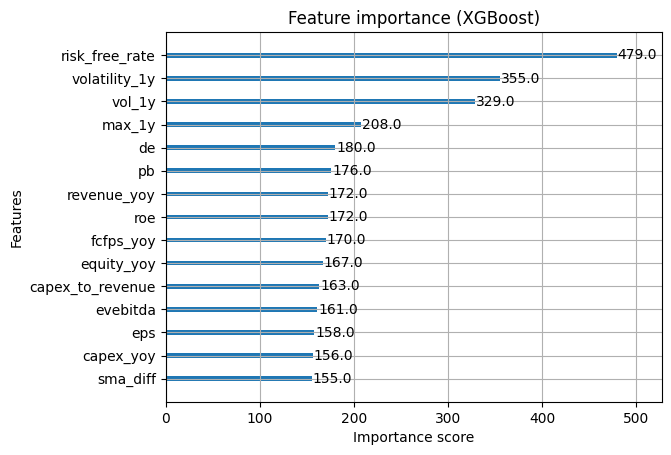

In [20]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(model, max_num_features=15)
plt.title("Feature importance (XGBoost)")
plt.show()


#### Matriz Recall

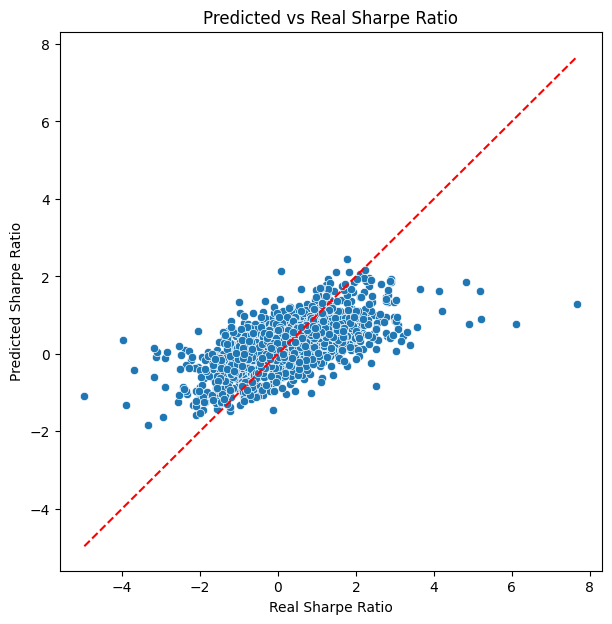

In [21]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Real Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.title('Predicted vs Real Sharpe Ratio')
plt.show()


#### Distribución de Residuals

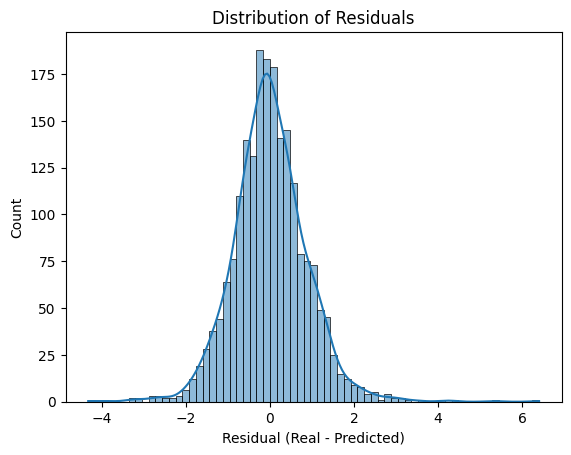

In [22]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Real - Predicted)")
plt.show()


#### Regression into classification 

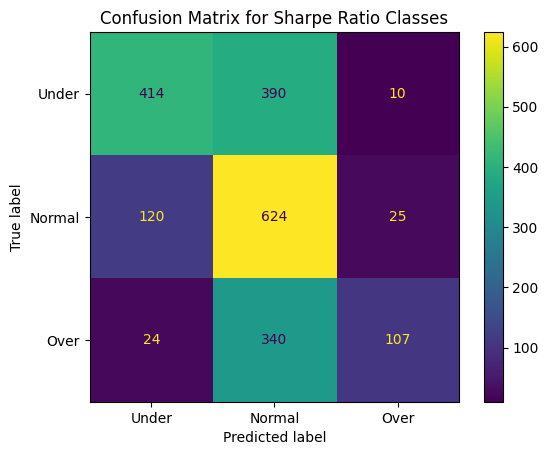

              precision    recall  f1-score   support

      Normal      0.461     0.811     0.588       769
 Overperform      0.754     0.227     0.349       471
Underperform      0.742     0.509     0.603       814

    accuracy                          0.557      2054
   macro avg      0.652     0.516     0.513      2054
weighted avg      0.639     0.557     0.539      2054



In [24]:
def sharpe_class(sr):
    if sr < 0:
        return "Underperform"
    elif sr < 1:
        return "Normal"
    else:
        return "Overperform"

# Apply to test set predictions and real values
y_test_class = y_test.apply(sharpe_class)
y_pred_class = pd.Series(y_pred).apply(sharpe_class)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_class, y_pred_class, labels=["Underperform", "Normal", "Overperform"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Under", "Normal", "Over"])
disp.plot()
plt.title("Confusion Matrix for Sharpe Ratio Classes")
plt.show()

print(classification_report(y_test_class, y_pred_class, digits=3))


In [25]:
results_df = data_base.loc[y_test.index, ['ticker', 'date']].copy()
results_df['sharpe_true'] = y_test
results_df['sharpe_pred'] = y_pred
results_df['sharpe_true_class'] = y_test_class.values
results_df['sharpe_pred_class'] = y_pred_class.values


In [26]:
over_df = results_df[results_df['sharpe_pred_class'] == 'Overperform']


In [28]:
over_df_sorted = over_df.sort_values(['date', 'ticker'])
display(over_df_sorted[['date', 'ticker']])



,date,ticker
305,2000-03-31,AEE
5965,2000-03-31,IKN
7719,2001-03-31,MO
1409,2003-03-31,BBY
2216,2003-03-31,CCTYQ
2803,2003-03-31,COR
3422,2003-03-31,DG1
3565,2003-03-31,DLX
4050,2003-03-31,EMN
4866,2003-03-31,GAS1


In [30]:
# Suponiendo que tu DataFrame de selección se llama 'selected_over_df'
# Y tu DataFrame completo es 'data_base' (con columna 'ret_12m_final')
selected_over_df = over_df_sorted.copy()

# Primero asegúrate de que las columnas de fechas sean del mismo tipo (ambos strings o ambos datetime)
selected_over_df['date'] = pd.to_datetime(selected_over_df['date'])
data_base['date'] = pd.to_datetime(data_base['date'])

# Haz el merge (unión) para añadir los retornos reales al DataFrame de seleccionados
portfolio_returns = pd.merge(
    selected_over_df,
    data_base[['date', 'ticker', 'target_12m_final']],
    on=['date', 'ticker'],
    how='left'
)


In [32]:
# Paso 1: Agrupa y calcula media por año (ignora NaN, pero agregamos fill_value más adelante)
annual_portfolio_return = portfolio_returns.groupby('date')['target_12m_final'].mean().reset_index()
annual_portfolio_return.rename(columns={'target_12m_final': 'portfolio_return'}, inplace=True)


# Paso 2: Crea un rango de fechas para todos los años posibles
all_years = pd.DataFrame({'date': data_base['date'].drop_duplicates().sort_values()})

# Une con los retornos y rellena años sin selección con 0
annual_portfolio_return = all_years.merge(
    annual_portfolio_return, on='date', how='left'
).fillna(0)

annual_portfolio_return['cumulative_return'] = (1 + annual_portfolio_return['portfolio_return']).cumprod()


In [33]:
print(annual_portfolio_return)


         date  portfolio_return  cumulative_return
0  2000-03-31          0.096401           1.096401
1  2001-03-31          0.162695           1.274780
2  2002-03-31          0.000000           1.274780
3  2003-03-31          0.532093           1.953082
4  2004-03-31          0.181188           2.306957
5  2005-03-31          0.000000           2.306957
6  2006-03-31          0.336063           3.082241
7  2007-03-31          0.000000           3.082241
8  2008-03-31          0.000000           3.082241
9  2009-03-31          1.052937           6.327646
10 2010-03-31          0.338246           8.467948
11 2011-03-31          0.000000           8.467948
12 2012-03-31          0.000000           8.467948
13 2013-03-31          0.315878          11.142789
14 2014-03-31          0.137845          12.678764
15 2015-03-31          0.000000          12.678764
16 2016-03-31          0.368296          17.348299
17 2017-03-31          0.000000          17.348299
18 2018-03-31          0.000000

## XGBOOST CON TIME SERIES SPLIT DATA

In [4]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd


# Si no está ordenado:
data_base = data_base.sort_values('date')

features = [
    col for col in data_base.columns 
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target')
]

X = data_base[features].copy().replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].copy().replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]


# Elige el número de splits, por ejemplo, 5 (ajusta según tu caso)
tscv = TimeSeriesSplit(n_splits=5)

mse_scores = []
r2_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.1, max_depth=6,
        subsample=0.7, colsample_bytree=0.7, random_state=42,
        early_stopping_rounds=15
    )
    
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    print(f"Fold {fold+1}: MSE={mse:.4f}, R2={r2:.4f}")

print(f"\nAverage MSE: {np.mean(mse_scores):.4f}")
print(f"Average R2: {np.mean(r2_scores):.4f}")


Fold 1: MSE=0.1152, R2=-0.1324
Fold 2: MSE=0.2357, R2=-0.1595
Fold 3: MSE=0.0609, R2=0.0134
Fold 4: MSE=0.1773, R2=0.1483
Fold 5: MSE=0.0832, R2=0.0393

Average MSE: 0.1344
Average R2: -0.0182


In [5]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
print("Top 10 features (último fold):")
for i in range(10):
    print(f"{X.columns[indices[i]]}: {importances[indices[i]]:.4f}")


Top 10 features (último fold):
risk_free_rate: 0.1022
ret_6m: 0.0998
vol_over_sma: 0.0459
dist_max_1y: 0.0398
volatility_1y: 0.0326
closeadj: 0.0325
ret_12m: 0.0268
ret_6m_vol: 0.0254
pb_yoy: 0.0250
log_marketcap: 0.0228


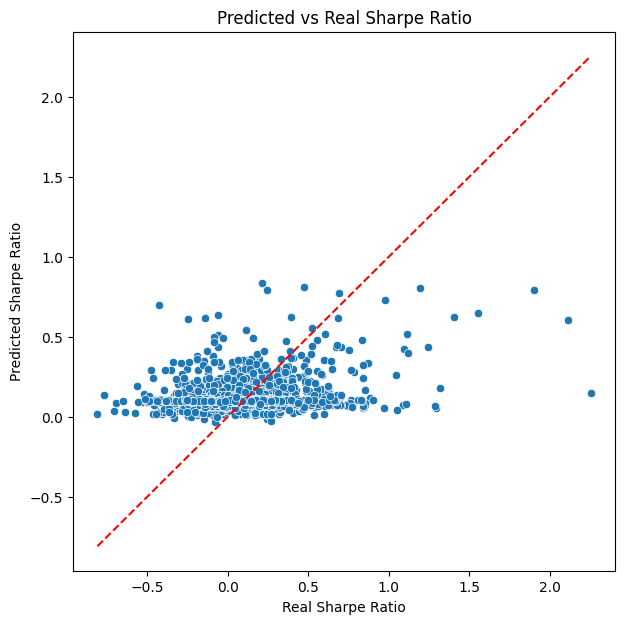

In [6]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Real Sharpe Ratio')
plt.ylabel('Predicted Sharpe Ratio')
plt.title('Predicted vs Real Sharpe Ratio')
plt.show()


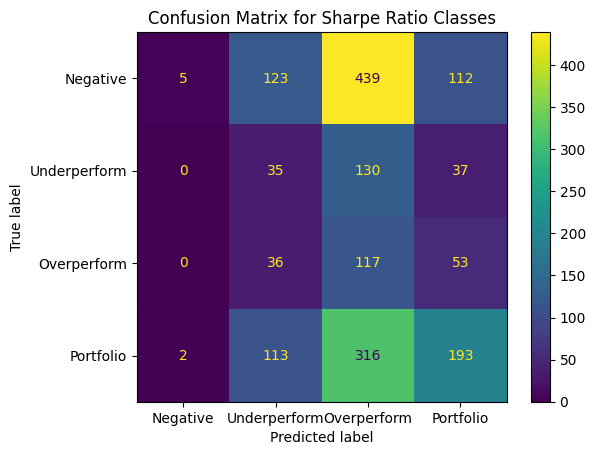

              precision    recall  f1-score   support

    Negative      0.714     0.007     0.015       679
 Overperform      0.117     0.568     0.194       206
   Portfolio      0.489     0.309     0.379       624
Underperform      0.114     0.173     0.138       202

    accuracy                          0.205      1711
   macro avg      0.358     0.264     0.181      1711
weighted avg      0.489     0.205     0.183      1711



In [7]:
def sharpe_class(sr):
    if sr < 0:
        return "Negative"
    elif sr < 0.07:
        return "Underperform"
    elif sr < 0.15:
        return "Overperform"
    else:
        return "Portfolio"

# Apply to test set predictions and real values
y_test_class = y_test.apply(sharpe_class)
y_pred_class = pd.Series(y_pred).apply(sharpe_class)

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_class, y_pred_class, labels=["Negative", "Underperform","Overperform", "Portfolio"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Underperform","Overperform", "Portfolio"])
disp.plot()
plt.title("Confusion Matrix for Sharpe Ratio Classes")
plt.show()

print(classification_report(y_test_class, y_pred_class, digits=3))


In [45]:
def sharpe_class(sr):
    if sr < 0.2:
        return "Underperform"
    elif sr < 0.9:
        return "Normal"
    else:
        return "Overperform"


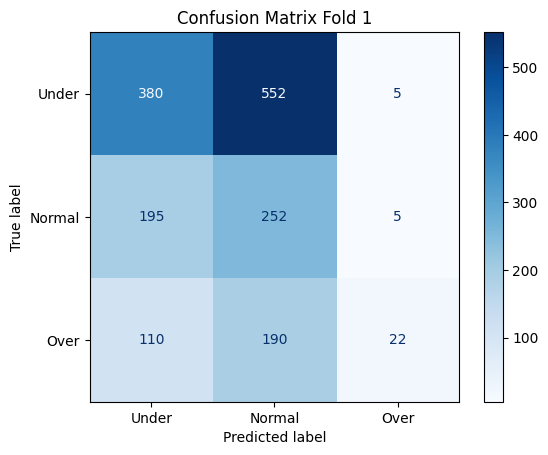

Fold 1:
               precision    recall  f1-score   support

      Normal      0.254     0.558     0.349       452
 Overperform      0.688     0.068     0.124       322
Underperform      0.555     0.406     0.469       937

    accuracy                          0.382      1711
   macro avg      0.499     0.344     0.314      1711
weighted avg      0.500     0.382     0.372      1711



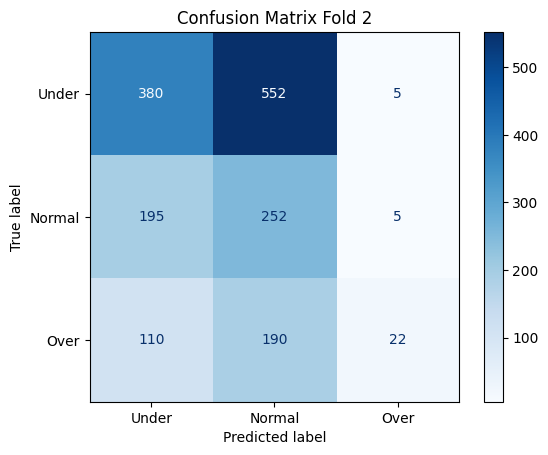

Fold 2:
               precision    recall  f1-score   support

      Normal      0.254     0.558     0.349       452
 Overperform      0.688     0.068     0.124       322
Underperform      0.555     0.406     0.469       937

    accuracy                          0.382      1711
   macro avg      0.499     0.344     0.314      1711
weighted avg      0.500     0.382     0.372      1711



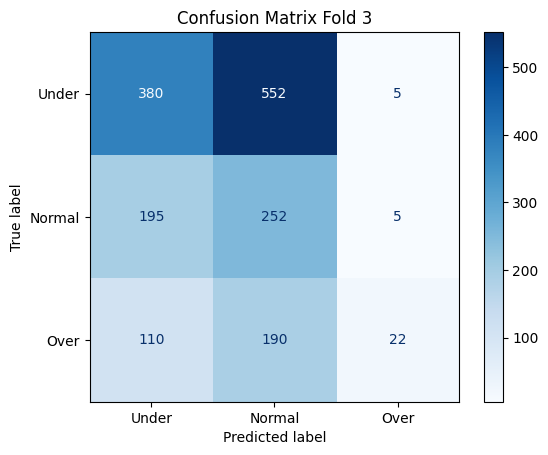

Fold 3:
               precision    recall  f1-score   support

      Normal      0.254     0.558     0.349       452
 Overperform      0.688     0.068     0.124       322
Underperform      0.555     0.406     0.469       937

    accuracy                          0.382      1711
   macro avg      0.499     0.344     0.314      1711
weighted avg      0.500     0.382     0.372      1711



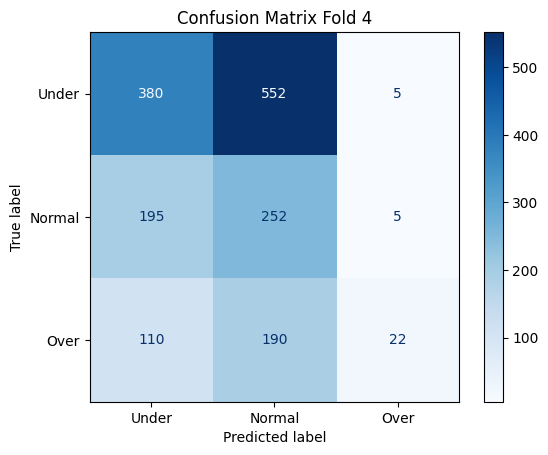

Fold 4:
               precision    recall  f1-score   support

      Normal      0.254     0.558     0.349       452
 Overperform      0.688     0.068     0.124       322
Underperform      0.555     0.406     0.469       937

    accuracy                          0.382      1711
   macro avg      0.499     0.344     0.314      1711
weighted avg      0.500     0.382     0.372      1711



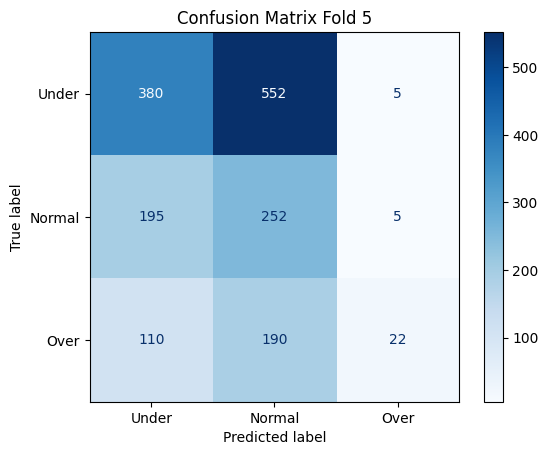

Fold 5:
               precision    recall  f1-score   support

      Normal      0.254     0.558     0.349       452
 Overperform      0.688     0.068     0.124       322
Underperform      0.555     0.406     0.469       937

    accuracy                          0.382      1711
   macro avg      0.499     0.344     0.314      1711
weighted avg      0.500     0.382     0.372      1711



In [47]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Dentro del bucle de TimeSeriesSplit...
for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # ...entrenas y predices como antes...

    # Clasifica
    y_test_class = pd.Series(y_test).apply(sharpe_class)
    y_pred_class = pd.Series(y_pred).apply(sharpe_class)
    
    # Matriz de confusión
    cm = confusion_matrix(y_test_class, y_pred_class, labels=["Underperform", "Normal", "Overperform"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Under", "Normal", "Over"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix Fold {fold+1}")
    plt.show()

    # Reporte de clasificación
    print(f"Fold {fold+1}:\n", classification_report(y_test_class, y_pred_class, digits=3))

In [125]:
portfolio_results = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    # Ya tienes X_test, y_test, y_pred
    y_test_class = pd.Series(y_test).apply(sharpe_class)
    y_pred_class = pd.Series(y_pred).apply(sharpe_class)
    
    # Recupera índices del test
    test_indices = y_test.index
    
    # DataFrame con datos originales + predicción
    test_df = data_base.loc[test_indices, ['date', 'ticker', 'target_12m_final']].copy()
    test_df['pred_class'] = y_pred_class.values
    test_df['true_class'] = y_test_class.values

    # Por cada año en este fold test, calcula el retorno equal-weight de los predichos "Overperform"
    for year in sorted(test_df['date'].unique()):
        year_df = test_df[test_df['date'] == year]
        # Selecciona los predichos como "Overperform"
        port_df = year_df[year_df['pred_class'] == "Portfolio"]
        if len(port_df) > 0:
            mean_return = port_df['target_12m_final'].mean()
        else:
            mean_return = 0
        portfolio_results.append({'date': year, 'fold': fold+1, 'portfolio_return': mean_return, 'n_stocks': len(port_df)})


In [126]:
returns_df = pd.DataFrame(portfolio_results)
returns_df = returns_df.sort_values(['date','fold'])

# Retorno acumulado por fold (por ejemplo)
returns_df['cumulative_return'] = returns_df.groupby('fold')['portfolio_return'].cumsum()


In [127]:
print(returns_df)

         date  fold  portfolio_return  n_stocks  cumulative_return
0  2020-03-31     1          0.701887        51           0.701887
5  2020-03-31     2          0.701887        51           0.701887
10 2020-03-31     3          0.701887        51           0.701887
15 2020-03-31     4          0.701887        51           0.701887
20 2020-03-31     5          0.701887        51           0.701887
1  2021-03-31     1          0.115824       228           0.817711
6  2021-03-31     2          0.115824       228           0.817711
11 2021-03-31     3          0.115824       228           0.817711
16 2021-03-31     4          0.115824       228           0.817711
21 2021-03-31     5          0.115824       228           0.817711
2  2022-03-31     1         -0.018298         7           0.799413
7  2022-03-31     2         -0.018298         7           0.799413
12 2022-03-31     3         -0.018298         7           0.799413
17 2022-03-31     4         -0.018298         7           0.79

--------------------------------------------------------------------------------------------------------------------------------------

# Resumen del Código

Este código implementa un pipeline de machine learning para predecir retornos financieros a 12 meses (`target_12m_final`) utilizando un modelo XGBoost. Respeta las series temporales ordenando los datos por fecha y emplea `TimeSeriesSplit` con 5 folds para evitar fugas temporales, asegurando que los datos de entrenamiento sean anteriores a los de prueba. Las características se seleccionan excluyendo columnas como `ticker`, `date`, y variables objetivo, reemplazando valores infinitos por `NaN` y filtrando filas con datos faltantes.

El modelo se entrena con hiperparámetros específicos y early stopping basado en un conjunto de validación (el propio conjunto de prueba de cada fold). Predice retornos numéricos, que luego se clasifican en categorías ("Negative", "Underperform", "Perform", "Overperform") según umbrales definidos. Se crea un DataFrame de prueba por fold con predicciones y datos originales, y se evalúa un portafolio hipotético de activos clasificados como "Overperform", calculando el retorno promedio y el número de activos por fecha.

Los resultados se agrupan por año, calculando el retorno promedio del portafolio y el número de acciones sobre los folds, y se deriva un retorno acumulado. Finalmente, se genera un gráfico de retorno acumulado a lo largo del tiempo usando `matplotlib`. El código no testea explícitamente apariciones nuevas (e.g., empresas que entran al S&P 500), excluyendo filas con datos faltantes, y usa el conjunto de prueba de cada fold como validación out-of-sample.

         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.134082     158.0           1.134082
1  2005-03-31          0.161509     428.0           1.317247
2  2006-03-31          0.122976     438.0           1.479236
3  2007-03-31         -0.073648     421.0           1.370293
4  2008-03-31         -0.263145     140.0           1.009708
5  2009-03-31          0.246846       3.0           1.258950
6  2010-03-31          0.195263     176.0           1.504776
7  2011-03-31          0.129912       9.0           1.700264
8  2012-03-31          0.209437      46.5           2.056363
9  2013-03-31          0.236133     402.0           2.541938
10 2014-03-31          0.134728     406.0           2.884408
11 2015-03-31         -0.007136     392.0           2.863824
12 2016-03-31          0.168896     177.0           3.347511
13 2017-03-31          0.137605     349.0           3.808146
14 2018-03-31          0.089709     307.0           4.149772
15 2019-03-31         -0

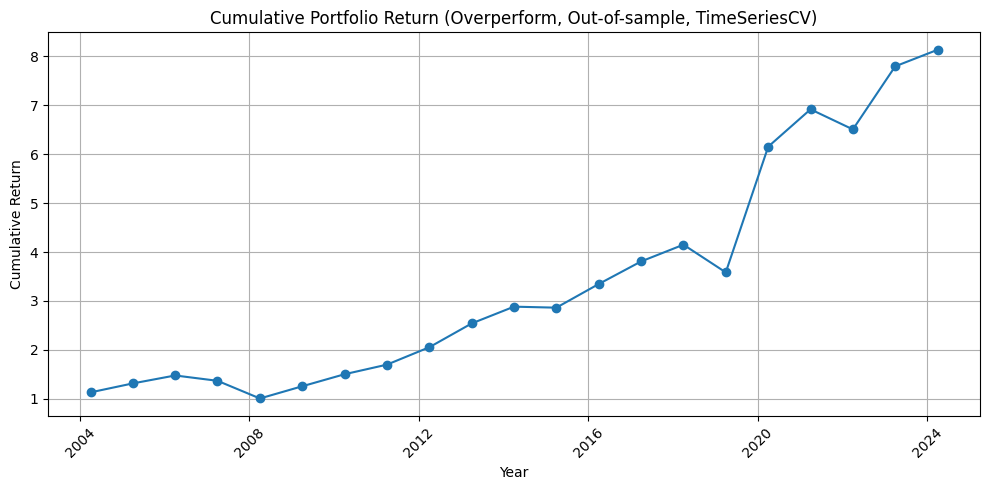

In [8]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd

# 0. Ordena por fecha para respetar la temporalidad
data_base = data_base.sort_values('date')

# 1. Define las features
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target')
]

X = data_base[features].replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = data_base.loc[mask].copy()

# 2. Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.07, max_depth=6,
        subsample=0.7, colsample_bytree=0.7, random_state=42,
        early_stopping_rounds=15
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)

    # 3. Clasificación: puedes ajustar los cortes si lo deseas
    def return_class(sr):
        if sr < 0.0:
            return "Negative"
        elif sr < 0.05:
            return "Underperform"
        elif sr < 0.08:
            return "Perform"
        else:
            return "Overperform"

    y_pred_class = pd.Series(y_pred).apply(return_class).values

    # 4. DataFrame solo test (añade tickers/fechas originales)
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
    df_test['predicted_return'] = y_pred
    df_test['predicted_class'] = y_pred_class
    df_test['fold'] = fold + 1

    # 5. Retorno del portfolio de Overperform en cada año
    for year, group in df_test.groupby('date'):
        overperf = group[group['predicted_class'] == 'Overperform']
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 6. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 7. Métrica ANUAL: promedio sobre los folds para cada año test
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 8. Retorno acumulado a lo largo de los años
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 9. (Opcional) Gráfico de retorno acumulado
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Out-of-sample, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()


In [9]:
results['date'].unique()

<DatetimeArray>
['2004-03-31 00:00:00', '2005-03-31 00:00:00', '2006-03-31 00:00:00',
 '2007-03-31 00:00:00', '2008-03-31 00:00:00', '2009-03-31 00:00:00',
 '2010-03-31 00:00:00', '2011-03-31 00:00:00', '2012-03-31 00:00:00',
 '2013-03-31 00:00:00', '2014-03-31 00:00:00', '2015-03-31 00:00:00',
 '2016-03-31 00:00:00', '2017-03-31 00:00:00', '2018-03-31 00:00:00',
 '2019-03-31 00:00:00', '2020-03-31 00:00:00', '2021-03-31 00:00:00',
 '2022-03-31 00:00:00', '2023-03-31 00:00:00', '2024-03-31 00:00:00']
Length: 21, dtype: datetime64[ns]

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Recalcula los labels verdaderos y predichos de Sharpe en todos los folds ---



# Recorremos cada fold y acumulamos los resultados reales y predichos
all_true = []
all_pred = []

tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.07, max_depth=6,
        subsample=0.7, colsample_bytree=0.7, random_state=42,
        early_stopping_rounds=15
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)

    all_true.extend(y_test.apply(sharpe_class).tolist())
    all_pred.extend(pd.Series(y_pred).apply(sharpe_class).tolist())

# --- Classification report y confusion matrix ---
labels = ["Underperform", "Normal", "Overperform"]

print(classification_report(all_true, all_pred, target_names=labels, digits=3))

cm = confusion_matrix(all_true, all_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Under", "Normal", "Over"])
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Out-of-Sample (All Folds)")
plt.show()


ValueError: Number of classes, 4, does not match size of target_names, 3. Try specifying the labels parameter

         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.136301     158.0           1.136301
1  2005-03-31          0.163995     427.0           1.322649
2  2006-03-31          0.123205     437.0           1.485605
3  2007-03-31         -0.073648     421.0           1.376194
4  2008-03-31         -0.399962     139.0           0.825768
5  2009-03-31          0.966266      79.0           1.623679
6  2010-03-31          0.211589     136.0           1.967231
7  2011-03-31         -0.013189      15.0           1.941285
8  2012-03-31          0.146722      44.0           2.226115
9  2013-03-31          0.235708     388.0           2.750827
10 2014-03-31          0.128757     358.0           3.105016
11 2015-03-31         -0.001026     334.0           3.101829
12 2016-03-31          0.195820     167.0           3.709230
13 2017-03-31          0.151473     327.0           4.271079
14 2018-03-31          0.083550     286.0           4.627928
15 2019-03-31         -0

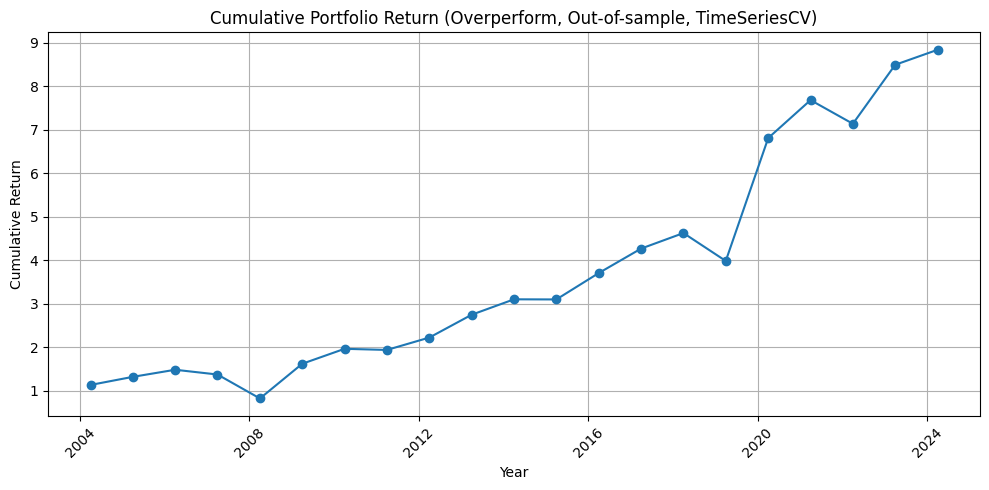

In [3]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


data_base = pd.read_csv('../data/data_base.csv', parse_dates=['date'])
# 0. Fijar semillas aleatorias para reproducibilidad
np.random.seed(43)  # Semilla para NumPy
# No es necesario random.seed() porque no usas el módulo random directamente

# 1. Ordena por fecha para respetar la temporalidad
data_base = data_base.sort_values('date')

# 2. Define las features
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target')
]

X = data_base[features].replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = data_base.loc[mask].copy()

# 3. Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=300, 
        learning_rate=0.07, 
        max_depth=6,
        subsample=0.7, 
        colsample_bytree=0.7, 
        random_state=43,  # Semilla para XGBoost
        early_stopping_rounds=15
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)

    # 4. Clasificación: puedes ajustar los cortes si lo deseas
    def return_class(sr):
        if sr < 0.0:
            return "Negative"
        elif sr < 0.05:
            return "Underperform"
        elif sr < 0.08:
            return "Perform"
        else:
            return "Overperform"

    y_pred_class = pd.Series(y_pred).apply(return_class).values

    # 5. DataFrame solo test (añade tickers/fechas originales)
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
    df_test['predicted_return'] = y_pred
    df_test['predicted_class'] = y_pred_class
    df_test['fold'] = fold + 1

    # 6. Retorno del portfolio de Overperform en cada año
    for year, group in df_test.groupby('date'):
        overperf = group[group['predicted_class'] == 'Overperform']
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 7. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 8. Métrica ANUAL: promedio sobre los folds para cada año test
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 9. Retorno acumulado a lo largo de los años
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 10. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Out-of-sample, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Promediando semillas y alterando parámetros

Este código implementa un pipeline de machine learning para predecir retornos financieros a 12 meses (`target_12m_final`) usando XGBoost, respetando series temporales con `TimeSeriesSplit` (5 folds). Las características se seleccionan excluyendo columnas como `ticker`, `date`, y variables objetivo, manejando valores faltantes. Para reducir la variabilidad en los resultados debido a la aleatoriedad, se promedia sobre múltiples semillas (`seeds=[42, 43, 44, 45, 46]`). En cada fold, se entrena el modelo, se predicen retornos, se clasifican en categorías ("Negative", "Underperform", "Perform", "Overperform") con umbrales fijos, y se evalúa un portafolio de activos "Overperform". Los resultados se promedian por año y semilla, calculando el retorno acumulado y visualizando su evolución temporal.

         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.133884     158.0           1.133884
1  2005-03-31          0.160853     427.8           1.316272
2  2006-03-31          0.122757     439.0           1.477855
3  2007-03-31         -0.073648     421.0           1.369014
4  2008-03-31         -0.349930     134.0           0.889955
5  2009-03-31          0.550635      26.2           1.379996
6  2010-03-31          0.236893     222.8           1.706907
7  2011-03-31         -0.035408       2.0           1.646469
8  2012-03-31          0.085566      45.4           1.787350
9  2013-03-31          0.233591     431.2           2.204858
10 2014-03-31          0.128549     438.8           2.488290
11 2015-03-31         -0.008424     440.8           2.467329
12 2016-03-31          0.169118     203.0           2.884598
13 2017-03-31          0.146795     356.8           3.308043
14 2018-03-31          0.077891     312.8           3.565711
15 2019-03-31         -0

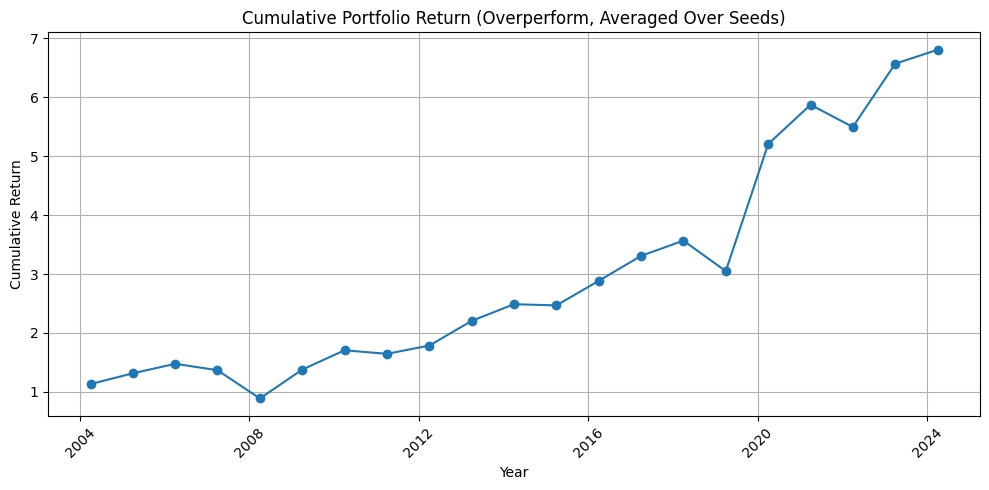

In [10]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Lista de semillas para promediar
seeds = [42, 43, 44, 45, 46]
all_results = []

for seed in seeds:
    # Fijar semillas para reproducibilidad dentro de cada iteración
    np.random.seed(seed)

    # 1. Ordena por fecha para respetar la temporalidad
    data_base = data_base.sort_values('date')

    # 2. Define las features
    features = [
        col for col in data_base.columns
        if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
        and not col.startswith('target')
    ]

    X = data_base[features].replace([np.inf, -np.inf], np.nan)
    y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
    mask = X.notnull().all(axis=1) & y.notnull()
    X = X.loc[mask]
    y = y.loc[mask]
    data_filtered = data_base.loc[mask].copy()

    # 3. Setup TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    result_list = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(
            n_estimators=300, 
            learning_rate=0.07, 
            max_depth=4,  # Reducido para estabilidad
            subsample=0.9,  # Aumentado
            colsample_bytree=0.9,  # Aumentado
            random_state=seed,  # Semilla por iteración
            early_stopping_rounds=10
        )
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)

        # 4. Clasificación
        def return_class(sr):
            if sr < 0.0:
                return "Negative"
            elif sr < 0.05:
                return "Underperform"
            elif sr < 0.08:
                return "Perform"
            else:
                return "Overperform"

        y_pred_class = pd.Series(y_pred).apply(return_class).values

        # 5. DataFrame solo test
        df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
        df_test['predicted_return'] = y_pred
        df_test['predicted_class'] = y_pred_class
        df_test['fold'] = fold + 1

        # 6. Retorno del portfolio de Overperform
        for year, group in df_test.groupby('date'):
            overperf = group[group['predicted_class'] == 'Overperform']
            if len(overperf) > 0:
                portfolio_return = overperf['target_12m_final'].mean()
                n_stocks = len(overperf)
            else:
                portfolio_return = 0.0
                n_stocks = 0
            result_list.append({
                'date': year,
                'fold': fold + 1,
                'portfolio_return': portfolio_return,
                'n_stocks': n_stocks,
                'seed': seed
            })

    # 7. DataFrame de resultados por semilla
    results = pd.DataFrame(result_list)
    results = results.sort_values(['date', 'fold'])
    all_results.append(results)

# 8. Promediar resultados sobre todas las semillas
all_results_df = pd.concat(all_results)
annual_results = all_results_df.groupby(['date']).agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 9. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 10. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Averaged Over Seeds)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Aproximamiento probabilisitco en determinar clases



         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.161174      27.0           1.161174
1  2005-03-31          0.232471      63.0           1.431114
2  2006-03-31          0.090875      65.0           1.561166
3  2007-03-31         -0.016449      59.0           1.535486
4  2008-03-31         -0.278514      18.5           1.107831
5  2009-03-31          0.572356       6.0           1.741905
6  2010-03-31          0.409046       5.0           2.454423
7  2011-03-31          0.022617      10.0           2.509935
8  2012-03-31          0.226180       6.5           3.077631
9  2013-03-31          0.254102      54.0           3.859664
10 2014-03-31          0.165449      55.0           4.498240
11 2015-03-31         -0.004755      56.0           4.476849
12 2016-03-31          0.191352      27.5           5.333505
13 2017-03-31          0.192395      45.0           6.359642
14 2018-03-31          0.133275      51.0           7.207220
15 2019-03-31         -0

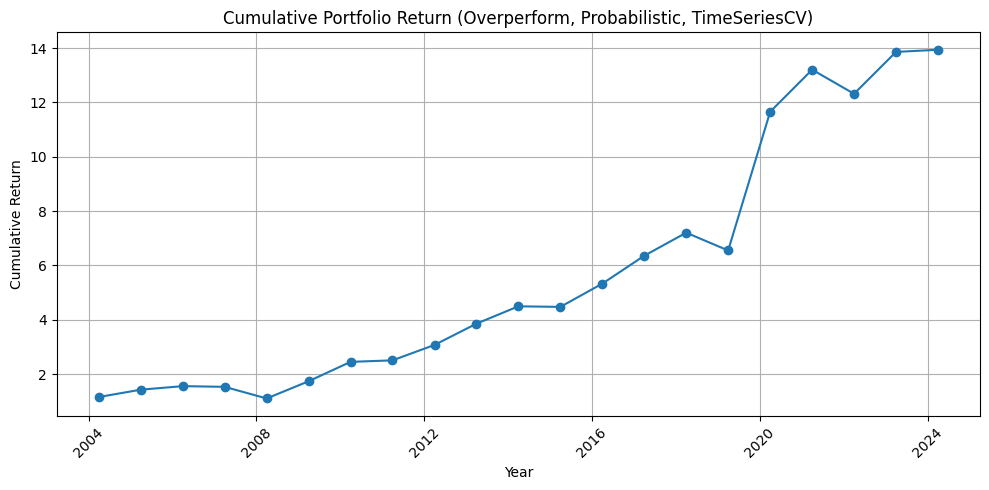

In [9]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Fijar semillas aleatorias para reproducibilidad
np.random.seed(42)

# 1. Ordena por fecha para respetar la temporalidad
data_base = data_base.sort_values('date')

# 2. Define las features y prepara datos
features = [
    col for col in data_base.columns
    if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
    and not col.startswith('target')
]

X = data_base[features].replace([np.inf, -np.inf], np.nan)
y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
mask = X.notnull().all(axis=1) & y.notnull()
X = X.loc[mask]
y = y.loc[mask]
data_filtered = data_base.loc[mask].copy()

# 3. Calcular distribución de retornos para calibración probabilística
return_bins = [-np.inf, 0.0, 0.05, 0.08, np.inf]  # Umbrales originales
return_labels = ["Negative", "Underperform", "Perform", "Overperform"]
# Corregido: Usar todas las etiquetas (4 etiquetas para 4 intervalos)
y_binned = pd.cut(y, bins=return_bins, labels=return_labels, include_lowest=True)
y_binned_counts = y_binned.value_counts(normalize=True)  # Probabilidades empíricas

# Ajustar umbrales con una función logística aproximada
def logistic_prob(return_value):
    thresholds = [0.0, 0.05, 0.08]
    probs = np.zeros(len(return_labels))
    for i, thresh in enumerate(thresholds + [np.inf]):
        if i == 0:
            probs[i] = 1 / (1 + np.exp(return_value - thresholds[i]))  # Prob Negative
        elif i == len(thresholds):
            probs[i] = 1 / (1 + np.exp(-(return_value - thresholds[i-1])))  # Prob Overperform
        else:
            probs[i] = (1 / (1 + np.exp(return_value - thresholds[i]))) - (1 / (1 + np.exp(return_value - thresholds[i-1])))  # Prob intermedia
    return probs / probs.sum()  # Normalizar para que sumen 1

# 4. Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
result_list = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(
        n_estimators=300,
        learning_rate=0.07,
        max_depth=4,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        early_stopping_rounds=10
    )
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    y_pred = model.predict(X_test)

    # 5. Clasificación probabilística
    prob_classes = np.array([logistic_prob(pred) for pred in y_pred])
    predicted_classes = [return_labels[np.argmax(probs)] for probs in prob_classes]
    predicted_probs = pd.DataFrame(prob_classes, columns=return_labels)

    # 6. DataFrame solo test
    df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
    df_test['predicted_return'] = y_pred
    df_test['predicted_class'] = predicted_classes
    for label in return_labels:
        df_test[f'prob_{label}'] = predicted_probs[label]
    df_test['fold'] = fold + 1

    # 7. Retorno del portfolio de Overperform (basado en probabilidad)
    for year, group in df_test.groupby('date'):
        overperf = group[group['prob_Overperform'] > 0.5]
        if len(overperf) > 0:
            portfolio_return = overperf['target_12m_final'].mean()
            n_stocks = len(overperf)
        else:
            portfolio_return = 0.0
            n_stocks = 0
        result_list.append({
            'date': year,
            'fold': fold + 1,
            'portfolio_return': portfolio_return,
            'n_stocks': n_stocks
        })

# 8. DataFrame de resultados
results = pd.DataFrame(result_list)
results = results.sort_values(['date', 'fold'])

# 9. Métrica ANUAL: promedio sobre los folds
annual_results = results.groupby('date').agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 10. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 11. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Probabilistic, TimeSeriesCV)")
plt.xlabel("Year")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()



# Aproximamiento probabilísitco pero promediando semillas

Este código implementa un pipeline de aprendizaje automático para predecir los retornos financieros a 12 meses (`target_12m_final`) utilizando el modelo XGBoost, respetando la naturaleza temporal de los datos mediante la ordenación por fecha y el uso de `TimeSeriesSplit` con 5 divisiones para evitar fugas de información. Las características se seleccionan excluyendo columnas como `ticker`, `date`, y variables objetivo, manejando valores faltantes mediante la sustitución de infinitos por `NaN` y filtrando filas incompletas. A diferencia de un enfoque determinista con umbrales fijos, se emplea una clasificación probabilística: los retornos predichos se transforman en probabilidades para las categorías "Negative", "Underperform", "Perform" y "Overperform" utilizando una función logística calibrada con la distribución histórica de los retornos. Los activos con una probabilidad superior al 50% de ser "Overperform" se seleccionan para formar un portafolio, cuyo retorno promedio y número de activos se calculan por fecha y fold. Para reducir la variabilidad observada al cambiar la semilla aleatoria (e.g., retornos del 400% con semilla 42 frente al 800% con semilla 43), se promedian los resultados sobre múltiples semillas (`[42, 43, 44, 45, 46]`), mejorando la robustez del modelo. Los resultados se agrupan por año, calculando el retorno acumulado, y se visualizan mediante un gráfico con `matplotlib`. Este enfoque probabilístico, combinado con el promedio de semillas, busca estabilizar las predicciones y ofrecer una estimación más fiable del rendimiento del portafolio.


         date  portfolio_return  n_stocks  cumulative_return
0  2004-03-31          0.207797      24.4           1.207797
1  2005-03-31          0.232471      63.0           1.488575
2  2006-03-31          0.090875      65.0           1.623850
3  2007-03-31         -0.016449      59.0           1.597138
4  2008-03-31         -0.292384      20.1           1.130161
5  2009-03-31          0.427647       7.0           1.613470
6  2010-03-31          0.351473       7.4           2.180562
7  2011-03-31          0.044183       7.6           2.276907
8  2012-03-31          0.158765       9.8           2.638399
9  2013-03-31          0.254242      53.6           3.309190
10 2014-03-31          0.166054      54.8           3.858694
11 2015-03-31         -0.003468      55.0           3.845313
12 2016-03-31          0.205580      26.6           4.635834
13 2017-03-31          0.197132      43.6           5.549706
14 2018-03-31          0.142251      49.0           6.339155
15 2019-03-31         -0

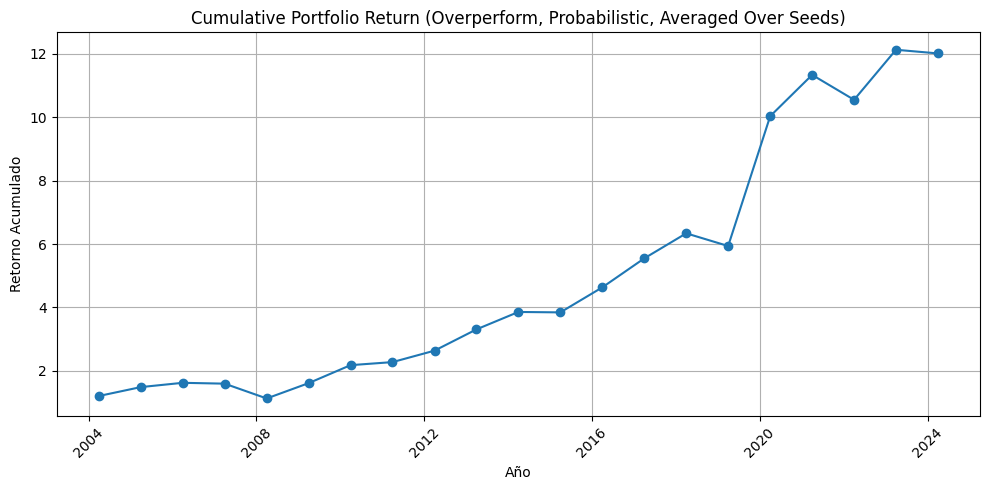

In [ ]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0. Lista de semillas para promediar y fijar reproducibilidad
seeds = [42, 43, 44, 45, 46]
all_results = []

for seed in seeds:
    # Fijar semilla para cada iteración
    np.random.seed(seed)

    # 1. Ordena por fecha para respetar la temporalidad
    data_base = data_base.sort_values('date')

    # 2. Define las features y prepara datos
    features = [
        col for col in data_base.columns
        if col not in ['ticker', 'date', 'cap_category', 'sharpe_1y', 'target_12m_final']
        and not col.startswith('target')
    ]

    X = data_base[features].replace([np.inf, -np.inf], np.nan)
    y = data_base['target_12m_final'].replace([np.inf, -np.inf], np.nan)
    mask = X.notnull().all(axis=1) & y.notnull()
    X = X.loc[mask]
    y = y.loc[mask]
    data_filtered = data_base.loc[mask].copy()

    # 3. Calcular distribución de retornos para calibración probabilística
    return_bins = [-np.inf, 0.0, 0.05, 0.08, np.inf]  # Umbrales originales
    return_labels = ["Negative", "Underperform", "Perform", "Overperform"]
    y_binned = pd.cut(y, bins=return_bins, labels=return_labels, include_lowest=True)
    y_binned_counts = y_binned.value_counts(normalize=True)  # Probabilidades empíricas

    # Ajustar umbrales con una función logística aproximada
    def logistic_prob(return_value):
        thresholds = [0.0, 0.05, 0.08]
        probs = np.zeros(len(return_labels))
        for i, thresh in enumerate(thresholds + [np.inf]):
            if i == 0:
                probs[i] = 1 / (1 + np.exp(return_value - thresholds[i]))  # Prob Negative
            elif i == len(thresholds):
                probs[i] = 1 / (1 + np.exp(-(return_value - thresholds[i-1])))  # Prob Overperform
            else:
                probs[i] = (1 / (1 + np.exp(return_value - thresholds[i]))) - (1 / (1 + np.exp(return_value - thresholds[i-1])))  # Prob intermedia
        return probs / probs.sum()  # Normalizar para que sumen 1

    # 4. Setup TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    result_list = []

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = xgb.XGBRegressor(

            n_jobs=1, # No paralelizar para evitar diferentes resultados por semilla -> No funciona DUDA!!
            n_estimators=300,
            learning_rate=0.07,
            max_depth=4,  # Reducido para estabilidad
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=seed,  # Semilla específica por iteración
            early_stopping_rounds=10
        )
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        y_pred = model.predict(X_test)

        # 5. Clasificación probabilística
        prob_classes = np.array([logistic_prob(pred) for pred in y_pred])
        predicted_classes = [return_labels[np.argmax(probs)] for probs in prob_classes]
        predicted_probs = pd.DataFrame(prob_classes, columns=return_labels)

        # 6. DataFrame solo test
        df_test = data_filtered.iloc[test_idx][['date', 'ticker', 'target_12m_final', 'sharpe_1y']].copy()
        df_test['predicted_return'] = y_pred
        df_test['predicted_class'] = predicted_classes
        for label in return_labels:
            df_test[f'prob_{label}'] = predicted_probs[label]
        df_test['fold'] = fold + 1

        # 7. Retorno del portfolio de Overperform (basado en probabilidad)
        for year, group in df_test.groupby('date'):
            overperf = group[group['prob_Overperform'] > 0.5]
            if len(overperf) > 0:
                portfolio_return = overperf['target_12m_final'].mean()
                n_stocks = len(overperf)
            else:
                portfolio_return = 0.0
                n_stocks = 0
            result_list.append({
                'date': year,
                'fold': fold + 1,
                'portfolio_return': portfolio_return,
                'n_stocks': n_stocks,
                'seed': seed  # Añadido para rastrear la semilla
            })

    # 8. DataFrame de resultados por semilla
    results = pd.DataFrame(result_list)
    results = results.sort_values(['date', 'fold'])
    all_results.append(results)

# 9. Promediar resultados sobre todas las semillas
all_results_df = pd.concat(all_results)
annual_results = all_results_df.groupby(['date']).agg({
    'portfolio_return': 'mean',
    'n_stocks': 'mean'
}).reset_index()

# 10. Retorno acumulado
annual_results['cumulative_return'] = (1 + annual_results['portfolio_return']).cumprod()

print(annual_results)

# 11. Gráfico de retorno acumulado
plt.figure(figsize=(10,5))
plt.plot(annual_results['date'], annual_results['cumulative_return'], marker='o')
plt.title("Cumulative Portfolio Return (Overperform, Probabilistic, Averaged Over Seeds)")
plt.xlabel("Año")
plt.ylabel("Retorno Acumulado")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

In [13]:
start = 1998
end = 2025

for year in range(start, end):
    unique_tickers = data_base[data_base['date'] == f'{year}-03-31']['ticker'].nunique()
    print(f"Año {year}: {unique_tickers} tickers únicos")


Año 1998: 0 tickers únicos
Año 1999: 416 tickers únicos
Año 2000: 472 tickers únicos
Año 2001: 469 tickers únicos
Año 2002: 476 tickers únicos
Año 2003: 488 tickers únicos
Año 2004: 490 tickers únicos
Año 2005: 494 tickers únicos
Año 2006: 494 tickers únicos
Año 2007: 492 tickers únicos
Año 2008: 493 tickers únicos
Año 2009: 496 tickers únicos
Año 2010: 497 tickers únicos
Año 2011: 496 tickers únicos
Año 2012: 494 tickers únicos
Año 2013: 494 tickers únicos
Año 2014: 496 tickers únicos
Año 2015: 497 tickers únicos
Año 2016: 491 tickers únicos
Año 2017: 497 tickers únicos
Año 2018: 496 tickers únicos
Año 2019: 496 tickers únicos
Año 2020: 496 tickers únicos
Año 2021: 499 tickers únicos
Año 2022: 496 tickers únicos
Año 2023: 498 tickers únicos
Año 2024: 498 tickers únicos
